In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt

In [10]:
target_col = 'precio' 

df_test = pd.read_csv('../data/preproccessed-pinamar-test.csv')
columnas_a_eliminar = [
    'direccion', 'descripcion', 'caracteristica', 'features_text', 
    'texto_completo', 'texto_analisis', 'texto_full_mar', 'texto_full_ubicacion',
    'm2_cubiertos_extract'
]

df_test = df_test.drop(columns=columnas_a_eliminar)

X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col].values


preprocessor = joblib.load('../models/trained_models/preprocesador_pinamar.pkl')
model_nn_log = tf.keras.models.load_model('../models/trained_models/modelo_casas_pinamar.keras')
model_gb_log = joblib.load('../models/trained_models/modelo_gb_log_pinamar.joblib')
model_gb_crudo = joblib.load('../models/trained_models/modelo_gb_crudo_pinamar.joblib')

X_test_proc = preprocessor.transform(X_test)

pred_log_nn = model_nn_log.predict(X_test_proc, verbose=0).flatten()
y_pred_nn = np.exp(pred_log_nn)


pred_log_gb = model_gb_log.predict(X_test_proc)
y_pred_gb_log = np.exp(pred_log_gb)

y_pred_gb_crudo = model_gb_crudo.predict(X_test_proc)


def evaluar_modelo(nombre, y_real, y_pred):
    r2 = r2_score(y_real, y_pred)
    mape = mean_absolute_percentage_error(y_real, y_pred) * 100
    mae = mean_absolute_error(y_real, y_pred)
    mediana_error = np.median(np.abs((y_real - y_pred) / y_real)) * 100
    
    return {
        'Modelo': nombre,
        'R2 Score': round(r2, 4),
        'MAPE (%)': round(mape, 2),
        'Error Mediano (%)': round(mediana_error, 2),
        'MAE (USD)': round(mae, 0)
    }

resultados = [
    evaluar_modelo('Red Neuronal Ajustada (Log)', y_test, y_pred_nn),
    evaluar_modelo('Gradient Boosting (Log)', y_test, y_pred_gb_log),
    evaluar_modelo('Gradient Boosting (Crudo)', y_test, y_pred_gb_crudo)
]


df_resultados = pd.DataFrame(resultados)

print("RESULTADOS EN EL DATASET DE TEST")
print(df_resultados.to_string(index=False))

RESULTADOS EN EL DATASET DE TEST
                     Modelo  R2 Score  MAPE (%)  Error Mediano (%)  MAE (USD)
Red Neuronal Ajustada (Log)    0.4659     24.25              20.99    88027.0
    Gradient Boosting (Log)    0.6096     16.41              13.25    65916.0
  Gradient Boosting (Crudo)    0.5908     17.74              12.90    67086.0


In [11]:
print("5 TASACIONES AL AZAR")
np.random.seed(900)

indices_azar = np.random.choice(len(y_test), size=5, replace=False)

muestra_azar = []

for idx in indices_azar:
    real = y_test[idx]
    
    p_nn = y_pred_nn[idx]
    p_gb_log = y_pred_gb_log[idx]
    p_gb_crudo = y_pred_gb_crudo[idx]
    
    err_nn = (np.abs(p_nn - real) / real * 100)
    err_gb_log = (np.abs(p_gb_log - real) / real * 100)
    err_gb_crudo = (np.abs(p_gb_crudo - real) / real * 100)
    
    muestra_azar.append({
        'ID Fila': f"#{idx}", 
        'Real (USD)': real,
        'NN (USD)': round(p_nn, 0),
        'Err NN (%)': round(err_nn, 1),
        'GB Log (USD)': round(p_gb_log, 0),
        'Err GB Log (%)': round(err_gb_log, 1),
        'GB Crudo (USD)': round(p_gb_crudo, 0),
        'Err GB Crudo (%)': round(err_gb_crudo, 1)
    })

df_azar = pd.DataFrame(muestra_azar)
print(df_azar.to_string(index=False))

5 TASACIONES AL AZAR
ID Fila  Real (USD)  NN (USD)  Err NN (%)  GB Log (USD)  Err GB Log (%)  GB Crudo (USD)  Err GB Crudo (%)
    #72      430000  463524.0         7.8      370225.0            13.9        384491.0              10.6
    #18      275000  289967.0         5.4      278005.0             1.1        278348.0               1.2
    #19      168000  212537.0        26.5      198711.0            18.3        180979.0               7.7
    #39      600000  372040.0        38.0      329157.0            45.1        319772.0              46.7
    #62       99000  180077.0        81.9      112381.0            13.5        102753.0               3.8


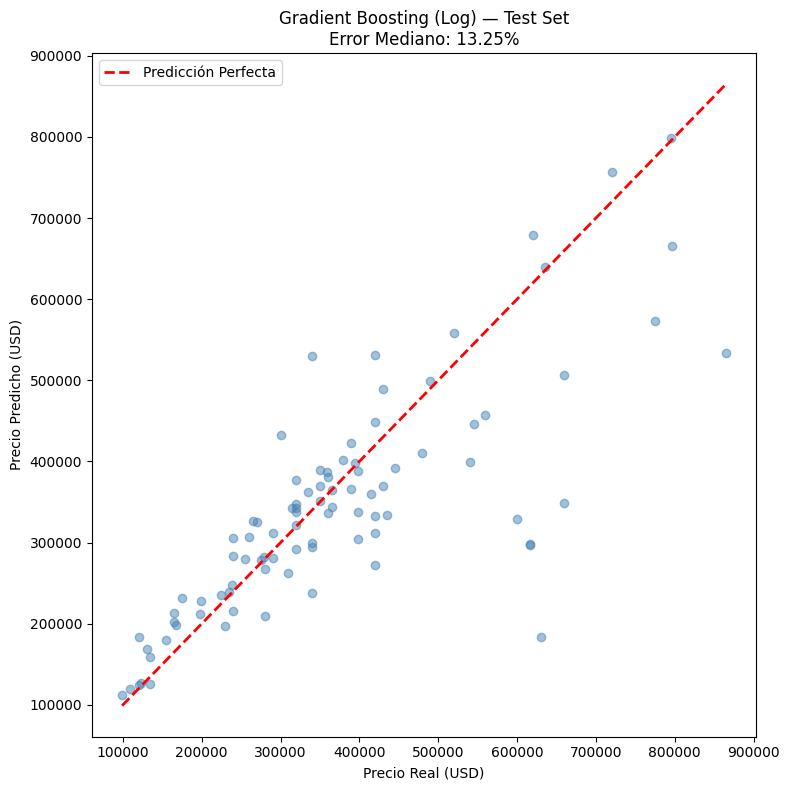

In [12]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_gb_log, alpha=0.5, color='steelblue')
lim = [min(y_test.min(), y_pred_gb_log.min()), max(y_test.max(), y_pred_gb_log.max())]
plt.plot(lim, lim, 'r--', linewidth=2, label='Predicción Perfecta')
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Gradient Boosting (Log) — Test Set\nError Mediano: 13.25%')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
print("ANÁLISIS DE 10 PEORES ERRORES EN TEST")

predicciones_test = {
    'Red Neuronal Ajustada (Log)': y_pred_nn,
    'Gradient Boosting (Log)': y_pred_gb_log,
    'Gradient Boosting (Crudo)': y_pred_gb_crudo
}

for nombre_modelo, y_pred in predicciones_test.items():

    df_errores = pd.DataFrame({
        'Precio Real (USD)': y_test,
        'Predicción (USD)': y_pred.round(0),
        'Diferencia (USD)': (y_pred - y_test).round(0),
        'Error (%)': (np.abs(y_pred - y_test) / y_test * 100).round(1)
    })
    
    top_10_peores = df_errores.sort_values(by='Error (%)', ascending=False).head(10)
    
    print(f"\nModelo: {nombre_modelo}")
    print(top_10_peores.to_string(index=False))

ANÁLISIS DE 10 PEORES ERRORES EN TEST

Modelo: Red Neuronal Ajustada (Log)
 Precio Real (USD)  Predicción (USD)  Diferencia (USD)  Error (%)
             99000          180077.0           81077.0       81.9
            340000          592985.0          252985.0       74.4
            630000          179080.0         -450920.0       71.6
            240000          411262.0          171262.0       71.4
            109000          182175.0           73175.0       67.1
            300000          468421.0          168421.0       56.1
            120000          185382.0           65382.0       54.5
            616000          313199.0         -302801.0       49.2
            865000          442620.0         -422380.0       48.8
            616000          319737.0         -296263.0       48.1

Modelo: Gradient Boosting (Log)
 Precio Real (USD)  Predicción (USD)  Diferencia (USD)  Error (%)
            630000          184154.0         -445846.0       70.8
            340000          530485

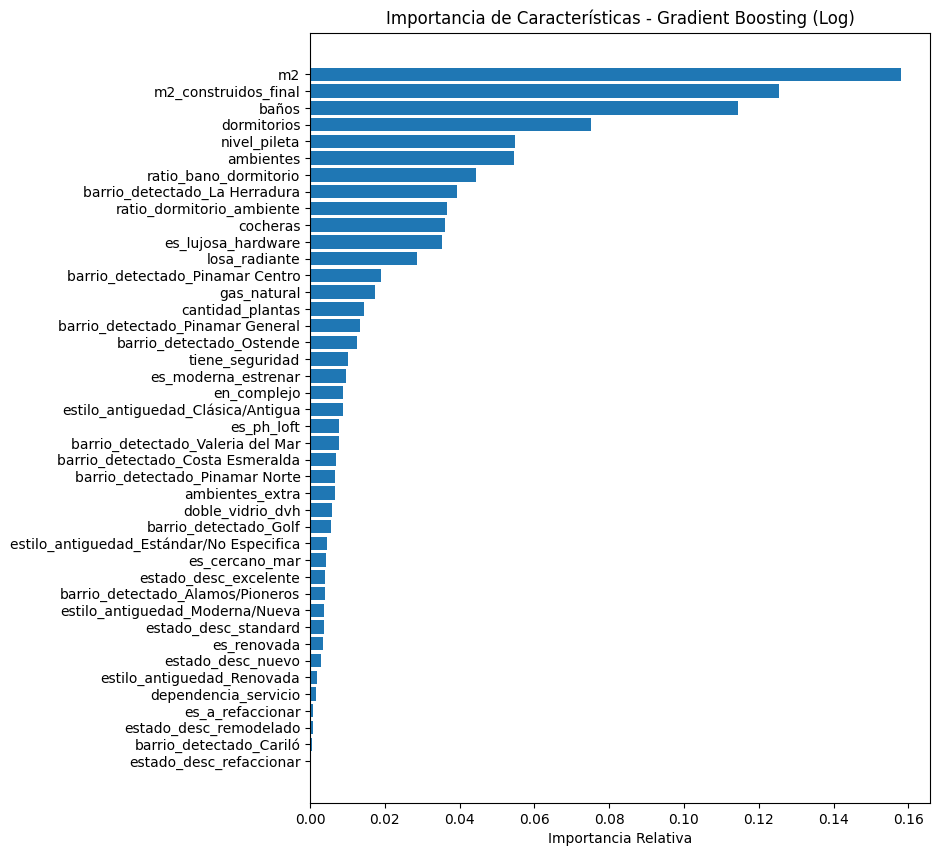

In [22]:
importances = model_gb_log.feature_importances_

feature_names = preprocessor.get_feature_names_out()

indices = np.argsort(importances)

plt.figure(figsize=(8, 10))
plt.title("Importancia de Características - Gradient Boosting (Log)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Importancia Relativa")
plt.show()